In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime 
from dateutil.relativedelta import relativedelta

%matplotlib inline 

pd.set_option('display.max_columns', 100)

# Introduction
I have recently gone back for an In-Camp Training (military service) and was catching up with a few of my army buddies. The most common topic that we were talking about was on investments. All of us are chasing the dream of creating a source of passive income, to attain financial freedom. Many of them were sharing their own investment strategies and insights to stocks that they have purchased. This was running through my mind at that point in time:

**_“Out of the hundreds and thousands of stocks that are available, how can I better narrow down to a handful of stocks that suits my risk appetite and have better than average returns, to do my due diligence on?”_**
 
I shall attempt to use K-Means clustering algorithm to answer this question. 

To narrow down my scope, I would be using stocks listed on NASDAQ and NYSE.

## Data Transformation

In [2]:
# 2006 - 2017 raw data is taken from Stocker python package which pulls from Quandl API
raw_data = pd.read_csv('./agg_df2_2012_onwards.csv', index_col=0)

C:\Users\timothy.ong\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\lib\arraysetops.py:522: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [3]:
raw_data.head()

,ticker,date,year,open,close
3428,MCBC,2012-01-03,2012,2.28,2.26
3429,MCBC,2012-01-04,2012,2.22,2.26
3430,MCBC,2012-01-05,2012,2.26,2.24
3431,MCBC,2012-01-06,2012,2.24,2.27
3432,MCBC,2012-01-09,2012,2.20,2.25


In [4]:
# 2018 raw data is taken from yahoo-finance package
df_2018 = pd.read_csv('./2018_data.csv', index_col=0)

In [5]:
df_2018.head(3)

,Open,High,Low,Close,Adj Close,Volume,date,ticker
0,26.450001,27.10,26.34,27.030001,27.030001,275200,2018-01-03,PRO
0,31.160000,31.16,30.00,30.780001,30.780001,168000,2018-12-29,PRO
0,9.990000,10.13,9.95,10.000000,9.775415,67600,2018-01-03,MCBC


In [6]:
# narrowing dataset to 2012 - 2017
# creating new column `year`
df_2012_2017 = (
    raw_data
    .pipe(lambda x: x.assign(year=pd.to_datetime(x.date).dt.year))
    .query("year >= 2012")
    [['ticker', 'date', 'year', 'open', 'close']]
)

`df_2012_2017` dataset provides the data for each stock performance on a daily basis, during the stated time period. I would like to obtain the annual performance of each stock. As such, I would need to identify the first and last trading day for each year.

In [7]:
# getting the first day and last day of each year that is available in the dataset
first_date_list = [df_2012_2017.query("year == '{}'".format(2012+i)).date.min() for i in range(6)]
last_date_list = [df_2012_2017.query("year == '{}'".format(2012+i)).date.max() for i in range(6)]
first_date_df =pd.DataFrame({"date": first_date_list}) 
last_date_df = pd.DataFrame({"date": last_date_list})

In [8]:
# filtering for the first day data in `df_2012_2017`
first_date_2012_2017_df = (
    df_2012_2017
    .merge(first_date_df, on='date', how='inner')
    .pipe(lambda x: x.assign(year=x.date.str[:4]))
    .rename(columns={"open": "open_first_day"})
    .reset_index(drop=True)
    [['ticker', 'year', 'open_first_day']]
    .pivot_table(values='open_first_day', columns='year', index='ticker', aggfunc='sum')
    .rename_axis(None, axis=1)
    .reset_index()
)

# filtering last day data in `df_2012_2017` 
last_date_2012_2017_df = (
    df_2012_2017
    .merge(last_date_df, on='date', how='inner')
    .pipe(lambda x: x.assign(year=x.date.str[:4]))
    .rename(columns={"close": "close_last_day"})
    .reset_index(drop=True)
    [['ticker', 'year', 'close_last_day']]
    .pivot_table(values='close_last_day', columns='year', index='ticker', aggfunc='sum')
    .rename_axis(None, axis=1)
    .reset_index()
)

In [9]:
# transforming 2018 data to be similar to the `first_date_2012_2017` and `last_date_2012_2017` dataframe
first_date_2018_df = (
    df_2018
    .query("date == '2018-01-03'")
    [['ticker', 'date', 'Open']]
    .pipe(lambda x: x.assign(year=pd.to_datetime(x.date).dt.year))
    .rename(columns={"Open": "open_first_day"})
    .reset_index(drop=True)
    [['ticker', 'year', 'open_first_day']]
    .pivot_table(values='open_first_day', columns='year', index='ticker', aggfunc='sum')
    .rename_axis(None, axis=1)
    .reset_index()
)

last_date_2018_df = (
    df_2018
    .query("date == '2018-12-29'")
    [['ticker', 'date', 'Close']]
    .pipe(lambda x: x.assign(year=pd.to_datetime(x.date).dt.year))
    .rename(columns={"Close": "close_last_day"})
    .reset_index(drop=True)
    [['ticker', 'year', 'close_last_day']]
    .pivot_table(values='close_last_day', columns='year', index='ticker', aggfunc='sum')
    .rename_axis(None, axis=1)
    .reset_index()
)

In [10]:
# merging 2012-2017 data with 2018 data
agg_first_date_df = (
    first_date_2012_2017_df
    .merge(first_date_2018_df, on='ticker', how='inner')
    .rename(columns=({2018: "2018"}))
    .melt(id_vars='ticker', value_vars=['2012', '2013', '2014', '2015', '2016', '2017', '2018'])
    .rename(columns={"variable": "year", "value": "open_first_day"})
)

agg_last_date_df = (
    last_date_2012_2017_df
    .merge(last_date_2018_df, on='ticker', how='inner')
    .rename(columns=({2018: "2018"}))
    .melt(id_vars='ticker', value_vars=['2012', '2013', '2014', '2015', '2016', '2017', '2018'])
    .rename(columns={"variable": "year", "value": "close_last_day"})
)

In [11]:
# calculating yearly return and then averaging them to get average yearly returns for each stock
agg_gains_df = (
    agg_first_date_df
    .merge(agg_last_date_df, on=['ticker', 'year'], how='inner')
    .pipe(lambda x: x.assign(gains_dollar=x.close_last_day-x.open_first_day))
    .pipe(lambda x: x.assign(gains_pctg=x.gains_dollar/x.open_first_day))
    .groupby("ticker")
    .agg({"gains_pctg": "mean"})
    .reset_index()
    .rename(columns={"gains_pctg": "avg_yearly_returns"})
)

# calculating overall variance using each year's return
agg_var_df = (
    agg_first_date_df
    .merge(agg_last_date_df, on=['ticker', 'year'], how='inner')
    .pipe(lambda x: x.assign(gains_dollar=x.close_last_day-x.open_first_day))
    .pipe(lambda x: x.assign(gains_pctg=x.gains_dollar/x.open_first_day))
    [['ticker', 'gains_pctg']]
    .groupby("ticker")
    .agg(np.var)
    .reset_index()
    .rename(columns={"gains_pctg": "variance"})
)

agg_df3 = (
    agg_gains_df
    .merge(agg_var_df, on='ticker', how='inner')
)

In [12]:
agg_df3.head()

,ticker,avg_yearly_returns,variance
0,AAN,0.080143,0.048170
1,AAON,0.100059,0.079516
2,AAP,0.165665,0.124715
3,AAPL,-0.005033,0.161882
4,ABC,0.131880,0.083416


In [13]:
agg_df3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1300 entries, 0 to 1299
Data columns (total 3 columns):
ticker                1300 non-null object
avg_yearly_returns    1300 non-null float64
variance              1300 non-null float64
dtypes: float64(2), object(1)
memory usage: 40.6+ KB


1300 stocks will be used for this study.

### Modelling

In [14]:
from sklearn.preprocessing import RobustScaler
from sklearn.cluster import KMeans
from sklearn import metrics

In [15]:
def plot_cluster(df, max_loop=50):
    """
    Looking at the performance of various number of clusters using K-Means.
    Performance is evaluated by within cluster SSE and silhouette score.
    """
    try:
        df.drop('cluster', axis=1, inplace=True)
    except:
        next
    X = df.iloc[:,1:]
    
    # robust scaling is used so that the centering and scaling statistics are therefore not influenced by a few number of very large marginal outliers as they are based on percentiles
    rb = RobustScaler()
    X_rb = rb.fit_transform(X)
    
    sse_within_cluster = {}
    silhouette_score = {}
    
    for k in range(2, max_loop):
        kmeans = KMeans(n_clusters=k,  random_state=10, n_init=10, n_jobs=-1)
        kmeans.fit(X_rb)
        sse_within_cluster[k] = kmeans.inertia_
        silhouette_score[k] = metrics.silhouette_score(X_rb, kmeans.labels_, random_state=10)

    _ = plt.figure(figsize=(10,6))
    ax1 = plt.subplot(211)
    _ = plt.plot(list(sse_within_cluster.keys()), list(sse_within_cluster.values()))
    _ = plt.xlabel("Number of Clusters")
    _ = plt.ylabel("SSE Within Cluster")
    _ = plt.title("Within Cluster SSE After K-Means Clustering")
    _ = plt.xticks([i for i in range(2, max_loop)], rotation=75)
    
    ax2 = plt.subplot(212)
    _ = plt.plot(list(silhouette_score.keys()), list(silhouette_score.values()))
    _ = plt.xlabel("Number of Clusters")
    _ = plt.ylabel("Silhouette Score")
    _ = plt.title("Silhouette Score After K-Means Clustering")
    _ = plt.xticks([i for i in range(2, max_loop)], rotation=75)
    
    plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.5, wspace=0.35)

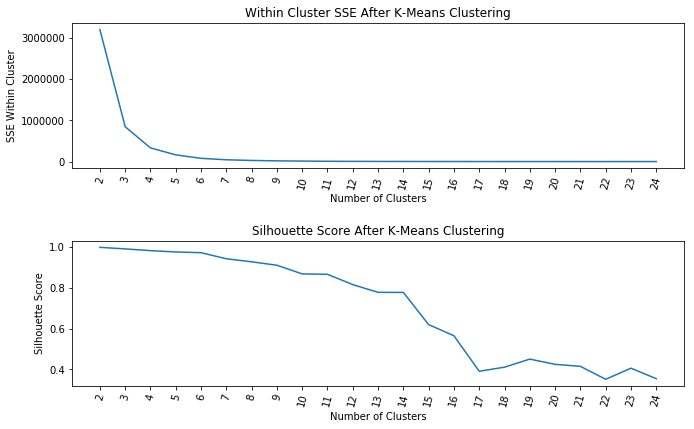

In [16]:
plot_cluster(agg_df3, max_loop=25)

From the first graph, `Within Cluster SSE After K-Means Clustering`, we can see that as the number of clusters increase pass 7, the sum of square of errors within clusters plateaus off. From the second graph, `Silhouette Score After K-Means Clustering`, we can see that there are various parts of the graph where a kink can be seen. Since there is not much a difference in SSE after 7 clusters and that the drop in sihouette score is quite significant between 14 clusters and 15 clusters, I would use 14 clusters in my K-Means model below.

In [17]:
def apply_cluster(df, clusters=2):
    """
    Applying K-Means with the optimal number of clusters identified
    """
    try:
        df.drop('cluster', axis=1, inplace=True)
    except:
        next
    X = df.iloc[:,1:]
    rb = RobustScaler()
    X_rb = rb.fit_transform(X)
    kmeans = KMeans(n_clusters=clusters, random_state=10, n_init=10, n_jobs=-1)  
    kmeans.fit(X_rb) 
    score = metrics.silhouette_score(X_rb, kmeans.labels_, random_state=10)
    df['cluster'] = kmeans.labels_
    sse_within_cluster = kmeans.inertia_
    
    print("clustering performance")
    print("-----------------------------------")
    print("silhouette score: " + str(score.round(2)))
    print("sse withing cluster: " + str(sse_within_cluster.round()))
    
    return df

In [18]:
first_trial = apply_cluster(agg_df3, clusters=14)

clustering performance
-----------------------------------
silhouette score: 0.78
sse withing cluster: 3237.0


In [19]:
cluster_perf_df = (
    first_trial
    .groupby('cluster')
    .agg({"avg_yearly_returns":"mean", "variance":"mean", "ticker":"count"})
    .sort_values('avg_yearly_returns')
    .reset_index()
)

cluster_perf_df

,cluster,avg_yearly_returns,variance,ticker
0,0,0.092419,0.110761,1193
1,11,0.336065,1.018290,59
2,8,0.593508,2.854767,19
3,12,0.837786,5.224438,11
4,6,1.067458,8.362185,5
5,10,1.331071,15.027225,3
6,4,1.836886,25.347059,3
7,9,2.420434,43.899749,1
8,13,2.602269,30.862794,1
9,7,3.340888,57.203435,1


From the dataframe above, we can see that the distribution of the stocks amongst the clusters is very skewed. Most of the stocks are aggregated in cluster `0`. For the other clusters, we can see that the `avg_yearly_returns` and `variance` are huge. A savvy investor would definitely not invest in these other clusters as the swing is too big, ranging from ~102% to 65100%. As such, he/she would most probably invest in a stock in cluster 0. As cluster 0 still contains too many stocks to choose from, I will attempt to conduct another K-Means clustering on cluster `0`.

In [20]:
# creating a dataframe that only consists of cluster `0`
agg_df3_sub = agg_df3.query("cluster == 0").reset_index(drop=True)

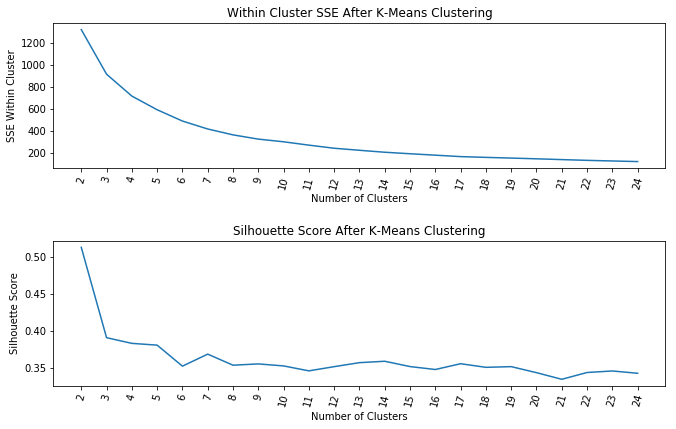

In [21]:
plot_cluster(agg_df3_sub, max_loop=25)

From the second graph, `Silhouette Score After K-Means Clustering`, we can see that there was a steep drop in silhouette score between 5 clusters and 6 clusters. As such, I would use 5 clusters in my K-Means model below.

In [22]:
second_trial= apply_cluster(agg_df3_sub, clusters=5)

clustering performance
-----------------------------------
silhouette score: 0.38
sse withing cluster: 591.0


In [23]:
sub_cluster_perf_df = (
    second_trial
    .groupby('cluster')
    .agg({"avg_yearly_returns":"mean", "variance":"mean", "ticker":"count"})
    .sort_values('avg_yearly_returns')
    .reset_index()
)

sub_cluster_perf_df

,cluster,avg_yearly_returns,variance,ticker
0,4,-0.080652,0.113519,184
1,3,0.044477,0.303681,84
2,0,0.081021,0.053163,603
3,2,0.206852,0.115717,257
4,1,0.297600,0.368385,65


From the dataframe above, we can see that cluster `0-0` and cluster `0-2` would be the 2 better clusters to invest, amongst the rest. Cluster `0-0` yields a decent return of 8.1% with a 5.3% variance, while cluster `0-2` yields a much higher return of 20.7%, with a correspondingly higher variance of 11.6%. I decided to add in Sharpe Ratio as a metric to better evaluate the cluster performance.

**_Sharpe Ratio is used to help investors understand the return of an investment compared to its risk. The ratio is the average return earned in excess of the risk-free rate per unit of volatility or total risk._**

Sharpe Ratio can be computed as such:

**$Sharpe\ Ratio = (R_s - R_f) /{SD_s}$**

I will be using the first day of the year, 5-years daily U.S. yield rates, from https://home.treasury.gov/ as the risk-free rate.

In [24]:
# calculating the average risk free rate over the time period of 2012 - 2018 
us_yield_curve_5years_dict = {"year": [2012, 2013, 2014, 2015, 2016, 2017, 2018],
                         "risk_free_rate": [0.89, 0.76, 1.72, 1.61, 1.73, 1.94, 2.25]}
us_yield_curve_5years_df = pd.DataFrame.from_dict(us_yield_curve_5years_dict)

avg_risk_free_rate = (
    us_yield_curve_5years_df
    .mean()
    [['risk_free_rate']]
    [0]
)

In [25]:
def get_sharpe_ratio_df(df):
    """
    Computing Sharpe Ratio
    """
    df_w_sharpe_ratio = (
        df
        .pipe(lambda x: x.assign(avg_risk_free_rate=avg_risk_free_rate/100))
        .pipe(lambda x: x.assign(std_dev=np.sqrt(x.variance)))
        .pipe(lambda x: x.assign(sharpe_ratio=(x.avg_yearly_returns-x.avg_risk_free_rate)/x.std_dev))
    )

    return df_w_sharpe_ratio

In [26]:
second_trial_w_sharpe_ratio = get_sharpe_ratio_df(second_trial)

In [27]:
def get_transform_df(df_w_sharpe_ratio):
    """
    Transforming dataframe so that I can plot a boxplot of `Returns`, `Variance` and `Sharpe Ratio` for each cluster
    """
    df_yearly_returns = (
        df_w_sharpe_ratio
        [['avg_yearly_returns', 'cluster']]
        .pipe(lambda x: x.assign(type='avg_yearly_returns'))
        .rename(columns={"avg_yearly_returns": "rate"})
    )

    df_variance = (
        df_w_sharpe_ratio
        [['variance', 'cluster']]
        .pipe(lambda x: x.assign(type='variance'))
        .rename(columns={"variance": "rate"})
    )

    df_sharpe_ratio = (
        df_w_sharpe_ratio
        [['sharpe_ratio', 'cluster']]
    )

    df_transform = pd.concat([df_yearly_returns, df_variance], axis=0)

    return df_transform, df_sharpe_ratio

In [28]:
sub_cluster_transform, sub_cluster_sharpe_ratio = get_transform_df(second_trial_w_sharpe_ratio)

In [29]:
def cluster_perf(transform_df, sharpe_ratio_df):
    """
    Plotting boxplot of cluster performance
    """
    _  = plt.figure(figsize=(15,7))

    ax1 = plt.subplot(121)
    _ = sns.boxplot(x='cluster', y='rate', hue='type', data=transform_df)
    _ = plt.title("Distribution of Returns and Variance for each Cluster")

    ax2 = plt.subplot(122)
    _ =sns.boxplot(x='cluster', y='sharpe_ratio', data=sharpe_ratio_df, color='royalblue')
    _ = plt.title("Distribution of Sharpe Ratio for each Cluster")

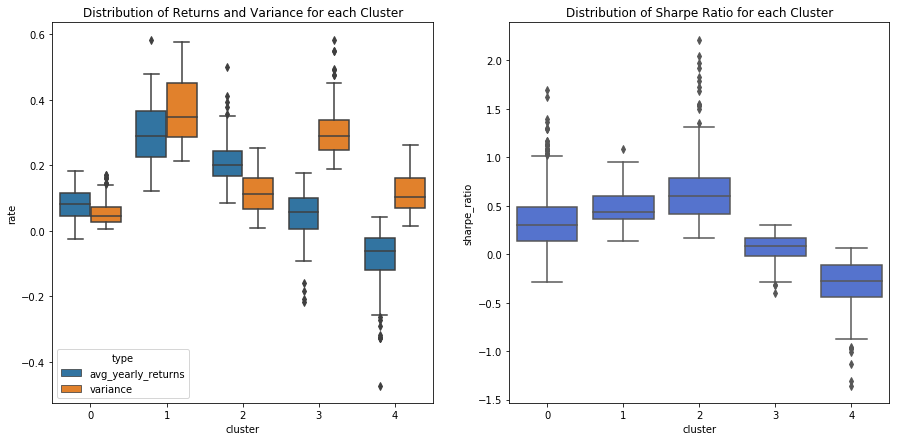

In [30]:
cluster_perf(sub_cluster_transform, sub_cluster_sharpe_ratio)

From the charts above, we can see that cluster `0-2` has the best Sharpe Ratio distribution amongst the rest and that its average returns (20.7%) and variance (11.6%) is still acceptable for my risk appetite. For someone who have a smaller risk appetite, he/she should be looking at cluster `0-0`, where the sharpe ratio is still fairly decent, along with moderate average returns (8.1%) and variance(5.3%)

Coupled with the fact that there are still more than 200 stocks in cluster `0-2` and there are some outliers (outperforming stocks) in that cluster, I would like to take segement it even further so that I can have a smaller group of stocks to research on.

In [31]:
# filtering out for cluster 1
best_sub_cluster = second_trial.query("cluster == 2")

C:\Users\timothy.ong\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


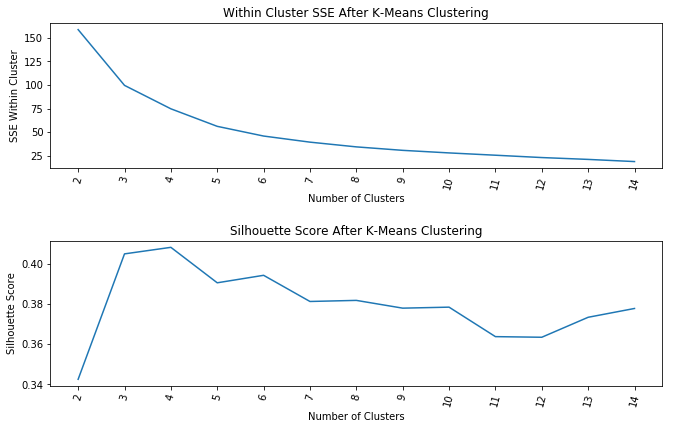

In [32]:
plot_cluster(best_sub_cluster, max_loop=15)

Based the above 2 graphs, I will use 6 clusters in my K-Means model below.

In [33]:
third_trial = apply_cluster(best_sub_cluster, clusters=6)

clustering performance
-----------------------------------
silhouette score: 0.39
sse withing cluster: 46.0


C:\Users\timothy.ong\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [34]:
best_sub_cluster_perf = (    
    third_trial
    .groupby('cluster')
    .agg({"avg_yearly_returns":"mean", "variance":"mean", "ticker":"count"})
    .sort_values('avg_yearly_returns')
    .reset_index()
)
best_sub_cluster_perf

,cluster,avg_yearly_returns,variance,ticker
0,4,0.126753,0.154927,37
1,0,0.179237,0.081487,73
2,2,0.191212,0.191096,36
3,3,0.239662,0.050322,57
4,5,0.251038,0.152885,43
5,1,0.367981,0.157878,11


In [35]:
third_trial_w_sharpe_ratio = get_sharpe_ratio_df(third_trial)

In [36]:
best_sub_cluster_transform, best_sub_cluster_sharpe_ratio = get_transform_df(third_trial_w_sharpe_ratio)

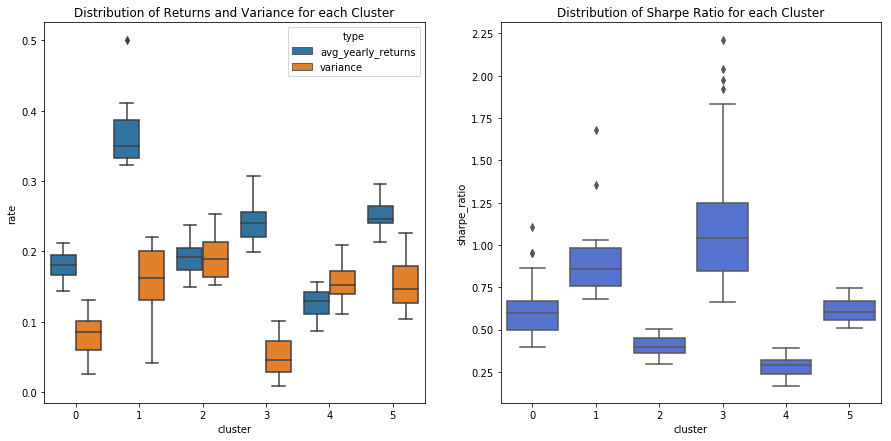

In [37]:
cluster_perf(best_sub_cluster_transform, best_sub_cluster_sharpe_ratio)

We can see that cluster `0-2-3` has the best sharpe ratio distribution and a very impressive average returns of 24.0% and variance of 5.0% (over the last 7 years). This golden cluster of 57 stocks definitely captured my attention and I should focused my research on them and create a portfolio based on them.

In [38]:
third_trial.query("cluster == 3").ticker.unique()

array(['ADSK', 'ANTM', 'AZPN', 'CACC', 'CHDN', 'CHE', 'CI', 'COO', 'DENN',
       'FDEF', 'FICO', 'FIS', 'FIX', 'HELE', 'HIFS', 'ICUI', 'IHC',
       'INTU', 'IT', 'JKHY', 'KAI', 'KWR', 'LFUS', 'LII', 'LION', 'LOW',
       'MCO', 'MLAB', 'MMSI', 'MOH', 'MSFT', 'MTD', 'MTN', 'NSP', 'OLBK',
       'OMCL', 'ORLY', 'PRSC', 'RDI', 'RHT', 'RMD', 'SBAC', 'SCHW', 'SCI',
       'SHEN', 'SHW', 'STE', 'TDY', 'TFX', 'TMO', 'TSS', 'ULTI', 'UNH',
       'USPH', 'VLO', 'VRSN', 'ZBRA'], dtype=object)

# Conclusion

In the first iteration of K-Means clustering, 14 clusters were formed. 13 of those clusters had extremely high returns and variance, stocks where no savvy investors would have purchased. As such, I have decided to conduct a second iteration on the remaining cluster, cluster `0`, that contains a majority of the stocks (1193 out of 1300 stocks). 

In the second iteration of K-Means clustering of the sub-cluster, 5 clusters were formed. As the performance of the clusters were fairly close, I have introduced a new metric, Sharpe Ratio, to better evaluate the performance of each cluster. From the Sharpe Ratio boxplot, it can be seen that cluster `0-2` was the better performing cluster as its Sharpe Ratio distribution was on the higher end. Since cluster `0-2` compromised of 257 stocks (still a fairly large number of stocks to study) and that there are some outliers in the Sharpe Ratio, I would like to take a more in-depth look into it, to see whether can I further narrow down to form a golden cluster.

In my third iteration of K-Means clustering of the sub-sub-cluster, 6 clusters were formed. From this last iteration, we can see a clear winner. Cluster `0-2-3` has the best Sharp Ratio distribution and that it has an impressive average returns of 24.0% and a variance of 5.0%, over the last 7 years. I should focus my research on this cluster (57 stocks) and choose the best stocks to invest in, based on fundamental analysis.